# Spilhaus and shipping

## Introduction

### Overview
The Spilhaus Projection, developed by Athelstan Spilhaus, is a map projection that shows the world's oceans as a single, unbroken body of water.  I thought it might be interesting to re-plot the shipping data that I had previously used in my blog post __"GeoPandas, rasterio, and shipping"__ [https://coolum001.github.io/dscale.html] in this projection.

### Projection
There have been some requests on GitHub for Cartopy to support the Spilhaus projection, but nothing appears to be supported in my version of Cartopy  (Cartopy is very much dependent on te `PROJ` project)

However, Phillip Brohan [https://brohan.org/] has blog post that shows how to approximate the projection, in __An equirectangular approximation to the Spilhaus projection: A map of the world arranged to highlight the ocean.__ [https://brohan.org/Posters/posters/Spilhaus/ostia.html]

We use the `RotatedPole` projection, described as:

>The class uses proj to perform an ob_tran operation, using the
    pole_longitude to set a lon_0 then performing two rotations based on
    pole_latitude and central_rotated_longitude.
    This is equivalent to setting the new pole to a location defined by
    the pole_latitude and pole_longitude values in the GeogCRS defined by
    globe, then rotating this new CRS about it's pole using the
    central_rotated_longitude value.




-------------------------
## Implementation

### Magics

`watermark` provides reproducability data, `lab_black` enforces a standard Python style

In [1]:
%load_ext watermark

In [2]:
%load_ext lab_black

### Imports

All imports appear here:
* `rasterio` supports raster operations
* `matplotlib` supports basic plotting
* `cartopy` supports mapping operations

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colors
import matplotlib

import rasterio
import rasterio.plot as riop
import rasterio.mask as riom
from rasterio.enums import Resampling

-------------------

### Data load

We use `rasterio` to access the dataset (a GEOTIFF).

In [4]:
URL = (
    "C:\\Data\\PythonMaps\\Shipping\\shipdensity_global.tif"
)

src = rasterio.open(URL)

Get the raster bounds: we need this to tell `matplotlib` the extent of the extent of the raster (in the `imshow` call)

In [5]:
src.bounds

BoundingBox(left=-180.015311275, bottom=-84.98735206299992, right=180.01468872500004, top=85.00264793700009)

We now read the data from our data source, downscaling by 16 (only using every 16-th row and column).  There is only one band in our array, which we will access by `data[0]`

In [6]:
upscale_factor = 1.0 / 16

data = src.read(
    out_shape=(
        src.count,
        int(src.height * upscale_factor),
        int(src.width * upscale_factor),
    ),
    resampling=Resampling.nearest,
)

----------------------------

## Visualization

### Define projection

We define a new projection, where the globe is rotated so that the point 113E, 32N is now at the top of the globe, and the globe is then rotated so that we are looking at 193E

In [7]:
rot_pole = ccrs.RotatedPole(
    pole_longitude=113,
    pole_latitude=32,
    central_rotated_longitude=193,
)

### Define colormap and norm

I struggled with the colormap.  I initially used `YlOrRd', which works fine with a black background.  However, here I wanted to have the oceans white (to show that the sea are mostly empty, and to distinguish them from land), but the small low-shipping-density pixels (in pale Yellow) just vanished against the white.  I eventually picked  a colormap that had reasonable contrast against white at both ends.

Note I have set the `bad value` color, and the `very low value` to 'none', which gives a fully transparent pixel

I also decided to ignore the very low shipping density pixels (set by the `norm` `vmin` parameter in `imshow` call)

In [8]:
my_cmap = matplotlib.colormaps['spring']
# my_cmap.set_bad(color='none')
# my_cmap.set_under('none')
my_cmap.set_bad(color='none')
my_cmap.set_under('none')

Another view of my color map

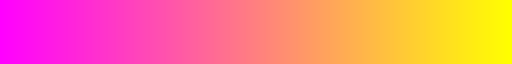

In [9]:
my_cmap

-----------------------------

## Create the map

Note that this map subverts our usual expectations.  The big land mass at the bottom of the map is South America, not Antarctica!

I draw in some lines of Latitude and Longitude to help orient the user in the map

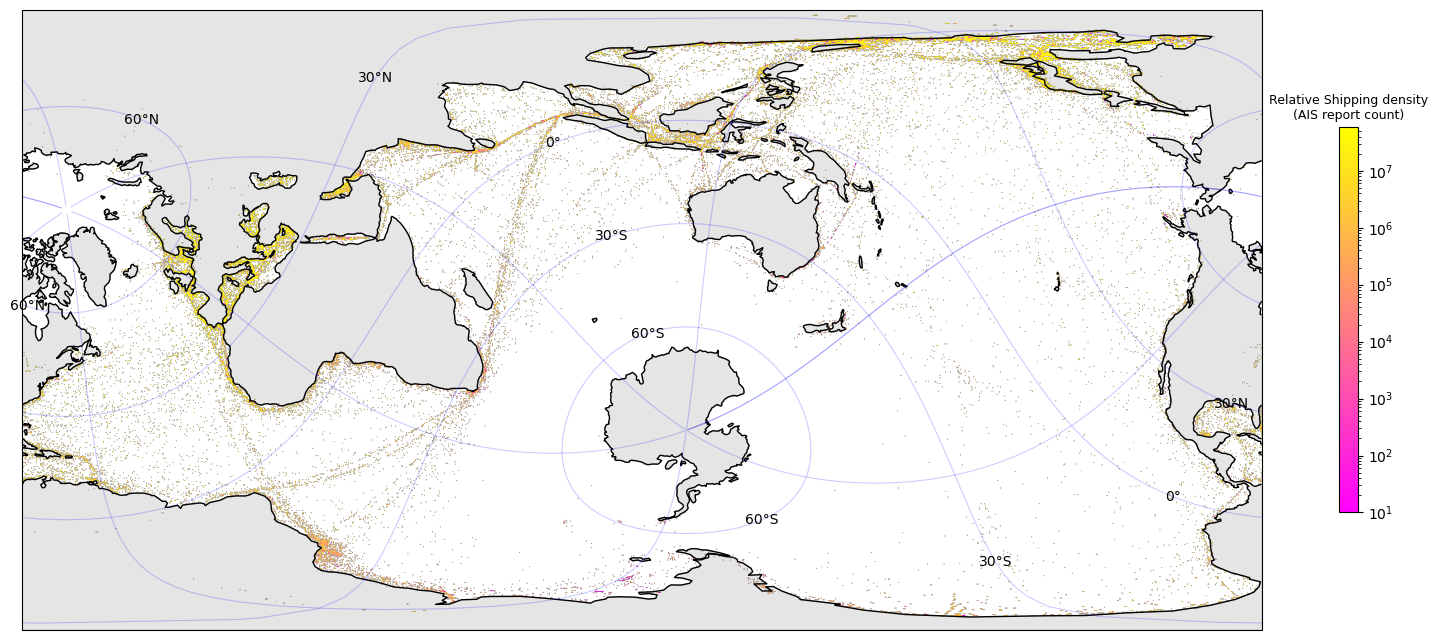

In [10]:
#  create a figure, with projection aware subplot
fig, ax = plt.subplots(
    figsize=(20, 20),
    subplot_kw={'projection': rot_pole},  # rot_pole},
)

# show the raster, with the extent we got earlier.
# we specify Plate Carree as the image projection
# we dont show pixels with a value < 10
pcm = ax.imshow(
    data[0],
    norm=colors.LogNorm(vmin=10),
    transform=ccrs.PlateCarree(),
    extent=[-180, 180, -85, 85],
    cmap=my_cmap,
)

# draw coastlines
ax.coastlines()

# add in the land as a light gray
ax.add_feature(
    cfeature.LAND,
    color='gray',
    alpha=0.2,
)


# draw gridlines:  labels to be shown on the map, lines in light blue
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    x_inline=True,
    y_inline=True,
    color='blue',
    alpha=0.2,
)

# create a colorbar on the right (default),
# from the ScalarMappable object returned by imshow
# we shrink it down, so it doesnt dominate the graphic
cbar = fig.colorbar(
    pcm,
    shrink=0.25,
)

# Set explanatory title on colorbar
cbar.ax.set_title(
    f'Relative Shipping density\n(AIS report count)',
    fontsize=9,
)
plt.show()

--------------------

## Conclusions

While not as dramatic as the maps with a black background, I think it serves to show that the North Atlantic, Indian Ocean, and the West Pacific are much busier than East or South Pacific Oceans.  I might create another map one day, just showing shipping fleets  (which are alleged to suppress AIS reports when fishing illegally, so I don't know how reliable that dataset might be)

--------------------------------

## Reproducability

In [11]:
%watermark

Last updated: 2025-05-14T13:02:50.458869+10:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 170 Stepping 4, GenuineIntel
CPU cores   : 22
Architecture: 64bit



In [12]:
%watermark -co  -iv -v -h

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

conda environment: pythonmaps

Hostname: INSPIRON16

cartopy   : 0.24.1
matplotlib: 3.10.0
rasterio  : 1.4.3

